In [1]:
!pip install -q PyGithub
!pip install -q pandas
!pip install -q matplotlib

In [2]:
from github import Github
import pandas as pd
from datetime import datetime
import pandas as pd
import os

import matplotlib.pyplot as plt

token = os.getenv("GITHUB_TOKEN")
# Authenticate with GitHub
g = Github(token)

# Get the repository
repo = g.get_repo("microsoft/terraform-provider-power-platform")

# Compute the average number of review comments per PR by category for AI-assisted vs non-ai-assisted PRs.
prs = []
pulls = repo.get_pulls(state="all")  # query all PRs, not filtering on closed
for pr in pulls:
    if pr.user.login == "dependabot[bot]":
        continue

    is_ai_assisted = any(label.name.lower() == 'ai assisted' for label in pr.labels)
    category = 'ai-assisted' if is_ai_assisted else 'non-ai-assisted'
        # Initialize variable to hold the earliest comment date
    first_comment_at = None

    # Check issue comments
    for comment in pr.get_issue_comments():
        if first_comment_at is None or comment.created_at < first_comment_at:
            first_comment_at = comment.created_at

    # Check review comments
    for comment in pr.get_review_comments():
        if first_comment_at is None or comment.created_at < first_comment_at:
            first_comment_at = comment.created_at

    prs.append({
        'review_comments': pr.review_comments,
        'first_comment_at': first_comment_at,

        'closed_at': pr.closed_at,
        'created_at': pr.created_at,
        'category': category
    })



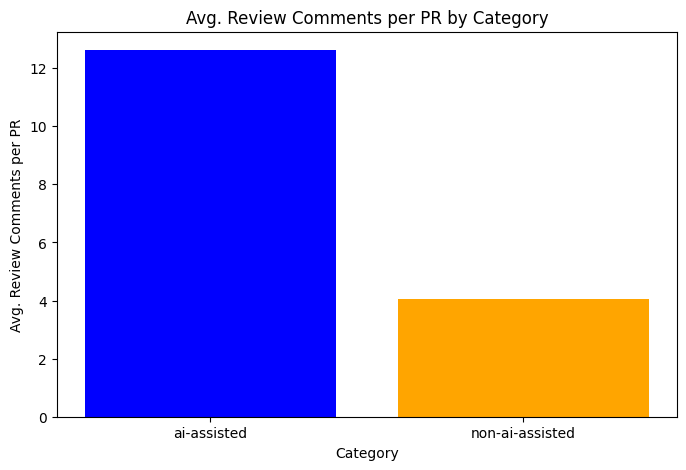

In [3]:
df_reviews = pd.DataFrame(prs)
avg_reviews = df_reviews.groupby('category')['review_comments'].mean().reset_index()

# Plot bar chart with one bar per category
plt.figure(figsize=(8, 5))
plt.bar(avg_reviews['category'], avg_reviews['review_comments'], color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Avg. Review Comments per PR')
plt.title('Avg. Review Comments per PR by Category')
plt.show()

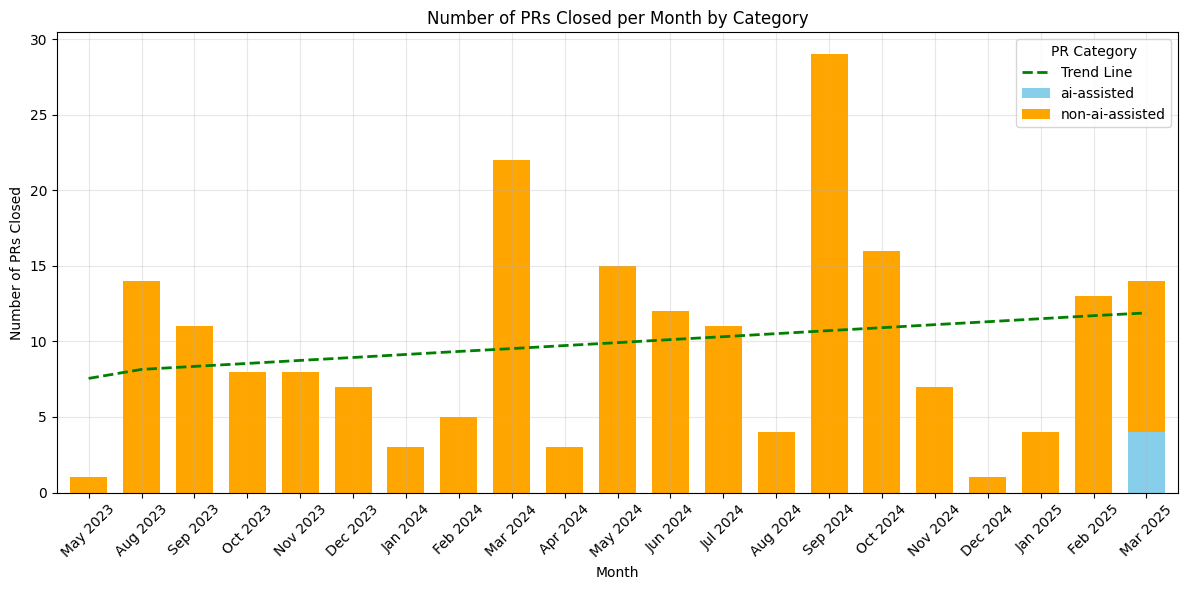

In [23]:
# Extract month from closed_at and count PRs per month, categorized by AI assistance
df['month'] = pd.to_datetime(df['closed_at']).dt.strftime('%Y-%m')
# Group by month and category, then count PRs
monthly_category_counts = df.groupby(['month', 'category']).size().unstack(fill_value=0)

# Convert index to datetime for proper sorting and plotting
monthly_category_counts.index = pd.to_datetime(monthly_category_counts.index + '-01')
monthly_category_counts = monthly_category_counts.sort_index()

# Calculate total counts for rolling average and trendline
monthly_counts = monthly_category_counts.sum(axis=1).reset_index()
monthly_counts.columns = ['month', 'pr_count']

# Calculate 3-month rolling average
rolling_avg = monthly_counts['pr_count'].rolling(window=3).mean()

# Create numeric X values for trendline calculation
x_numeric = np.array([(date - monthly_counts['month'].iloc[0]).days for date in monthly_counts['month']])
y = monthly_counts['pr_count'].values

# Calculate the trendline using polyfit
z = np.polyfit(x_numeric, y, 1)
p = np.poly1d(z)
trendline = p(x_numeric)

# Create the stacked bar chart with lines
plt.figure(figsize=(12, 6))

# Plot stacked bars
monthly_category_counts.plot(kind='bar', stacked=True, ax=plt.gca(), 
                            color=['skyblue', 'orange'], width=0.7)

# Plot rolling average and trendline on secondary axis
#plt.plot(range(len(monthly_counts)), rolling_avg, 'r-', linewidth=2, label='3-Month Rolling Average')
plt.plot(range(len(monthly_counts)), trendline, 'g--', linewidth=2, label='Trend Line')

# Format x-axis labels to Month Year format
ax = plt.gca()
labels = [date.strftime('%b %Y') for date in monthly_category_counts.index]
ax.set_xticklabels(labels)

plt.xlabel('Month')
plt.ylabel('Number of PRs Closed')
plt.title('Number of PRs Closed per Month by Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='PR Category')
plt.tight_layout()
plt.show()


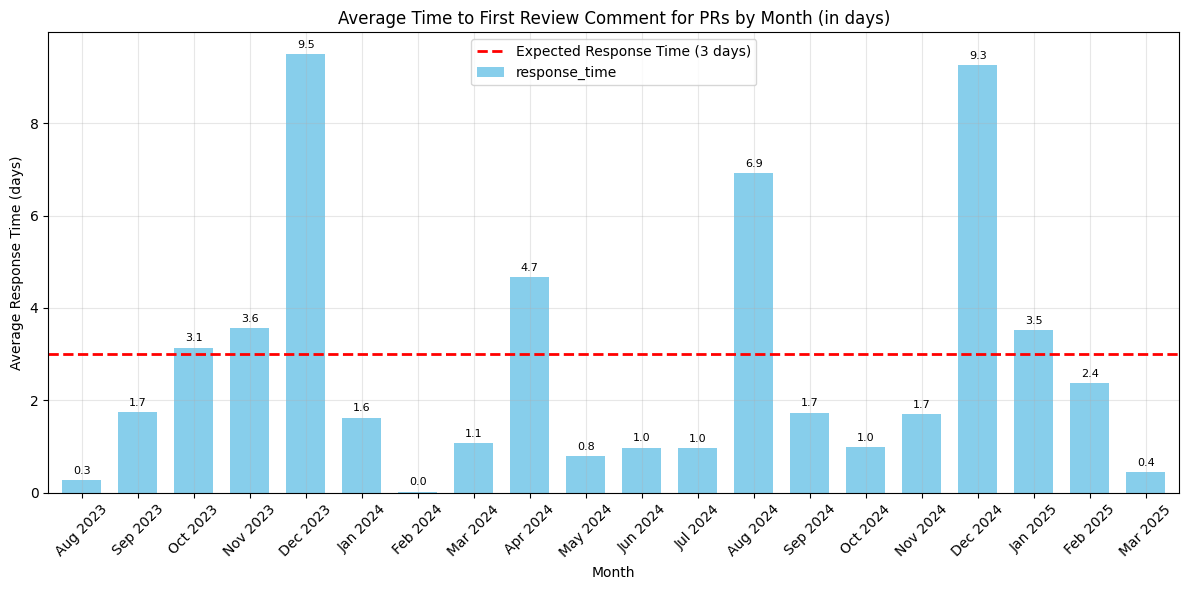

In [35]:
# Filter out rows where first_comment_at is None
df_with_comments = pd.DataFrame(prs).dropna(subset=['first_comment_at'])

# Calculate time difference between first comment and PR creation in days
df_with_comments['response_time'] = (df_with_comments['first_comment_at'] - df_with_comments['created_at']).dt.total_seconds() / (3600 * 24)

# Extract month from created_at for grouping
df_with_comments['creation_month'] = pd.to_datetime(df_with_comments['created_at']).dt.strftime('%Y-%m')

# Group by month and calculate average response time (no category grouping)
monthly_response_times = df_with_comments.groupby('creation_month')['response_time'].mean()

# Convert index to datetime for proper sorting
monthly_response_times.index = pd.to_datetime(monthly_response_times.index + '-01')
monthly_response_times = monthly_response_times.sort_index()

# Create the bar chart
plt.figure(figsize=(12, 6))
ax = monthly_response_times.plot(kind='bar', color='skyblue', width=0.7)

# Add data labels to the top of the bars
ax.bar_label(ax.containers[0], fmt='{:.1f}', padding=3, fontsize=8)

# Format x-axis labels to Month Year format
labels = [date.strftime('%b %Y') for date in monthly_response_times.index]
ax.set_xticklabels(labels)

# Add a horizontal dotted line at 3 days to show the expected response time
plt.axhline(y=3, color='r', linestyle='--', linewidth=2, label='Expected Response Time (3 days)')

plt.xlabel('Month')
plt.ylabel('Average Response Time (days)')
plt.title('Average Time to First Review Comment for PRs by Month (in days)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


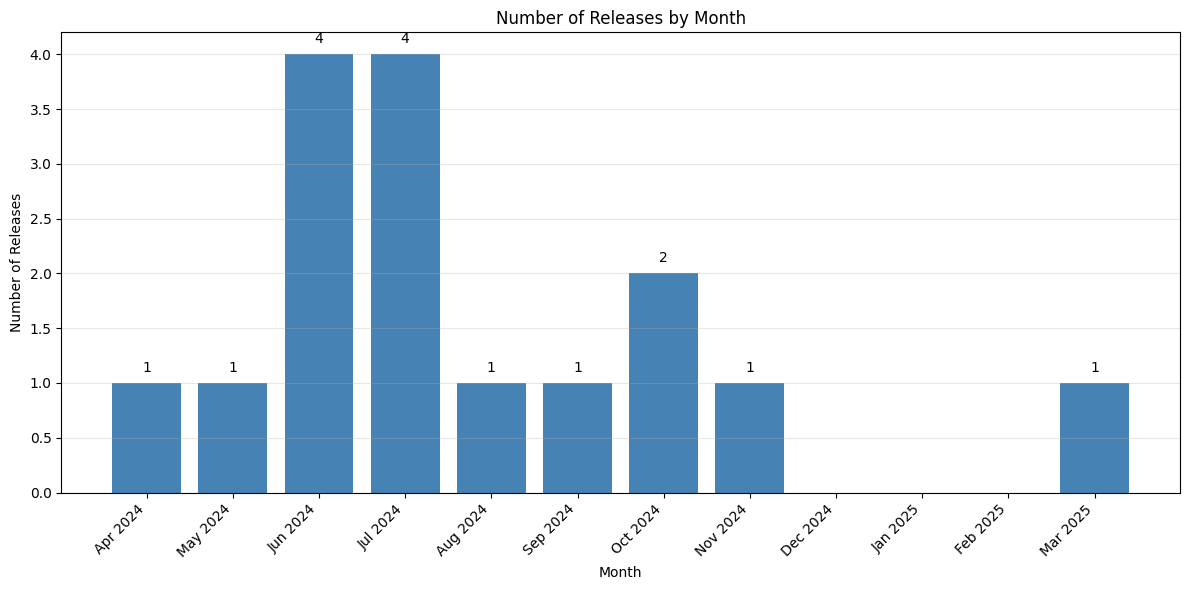

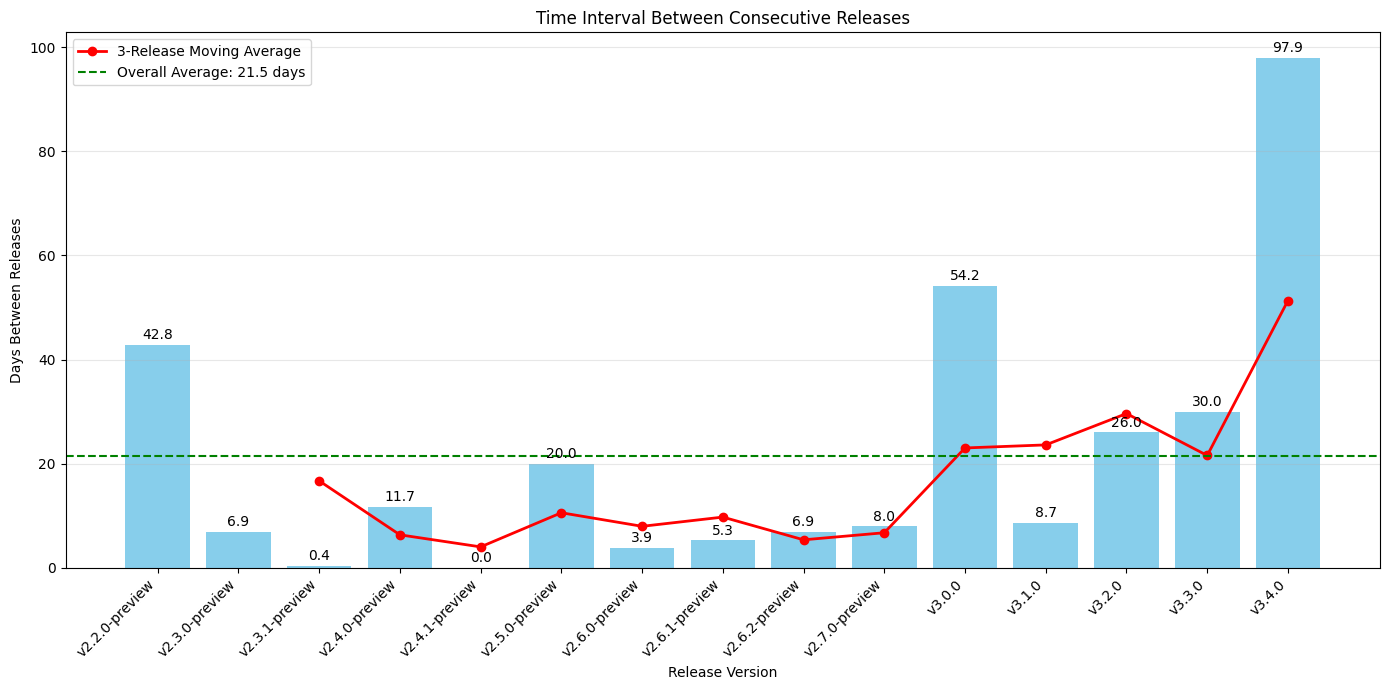

In [42]:
# Extract month and year from each release's published_at date
release_dates = []
for release in releases:
    release_dates.append({
        'month_year': release.published_at.strftime('%Y-%m'),
        'title': release.title,
        'published_at': release.published_at
    })

# Create DataFrame and count releases by month
df_releases = pd.DataFrame(release_dates)
monthly_releases = df_releases.groupby('month_year').size().reset_index(name='count')

# Convert month_year to datetime for proper sorting
monthly_releases['month_year'] = pd.to_datetime(monthly_releases['month_year'] + '-01')
monthly_releases = monthly_releases.sort_values('month_year')

# Create bar chart
plt.figure(figsize=(12, 6))
# Get the min and max dates
min_date = monthly_releases['month_year'].min()
max_date = monthly_releases['month_year'].max()

# Create a range of all months between min and max date
all_months = pd.date_range(start=min_date, end=max_date, freq='MS')
df_all_months = pd.DataFrame({'month_year': all_months})

# Left join with the original data to get counts (fills with NaN for months with no releases)
complete_df = df_all_months.merge(
    monthly_releases[['month_year', 'count']], 
    on='month_year', 
    how='left'
)

# Fill NaN values with 0 (months with no releases)
complete_df['count'] = complete_df['count'].fillna(0).astype(int)

# Plot the chart with all months
bars = plt.bar(range(len(complete_df)), complete_df['count'], color='steelblue')

# Format x-axis labels to Month Year format
plt.xticks(range(len(complete_df)), 
           [date.strftime('%b %Y') for date in complete_df['month_year']], 
           rotation=45, ha='right')

# Add data labels on bars with non-zero height
for bar in bars:
    height = bar.get_height()
    if height > 0:  # Only label non-zero bars
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               str(int(height)), ha='center')

plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.title('Number of Releases by Month')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate time intervals between releases
intervals_days = []
release_titles = []

# Sort releases by published_at date
sorted_releases = sorted(release_dates, key=lambda x: x['published_at'])

# Calculate the intervals
for i in range(1, len(sorted_releases)):
    current = sorted_releases[i]
    previous = sorted_releases[i-1]
    interval = current['published_at'] - previous['published_at']
    # Convert to days with decimal precision
    interval_days = interval.days + interval.seconds / (24 * 3600)
    intervals_days.append(interval_days)
    release_titles.append(current['title'])

# Calculate moving average (last 3 releases)
moving_avg = []
for i in range(len(intervals_days)):
    if i < 2:  # Not enough data for 3-point average
        moving_avg.append(None)
    else:
        avg = sum(intervals_days[i-2:i+1]) / 3
        moving_avg.append(avg)

# Create the plot
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(release_titles)), intervals_days, color='skyblue')

# Add moving average line - start from the 3rd release
x_values = range(2, len(release_titles))
y_values = moving_avg[2:]  # Skip first two None values
plt.plot(x_values, y_values, 'r-', linewidth=2, 
         label='3-Release Moving Average', marker='o')

# Add average line
avg_interval_days = sum(intervals_days) / len(intervals_days)
plt.axhline(y=avg_interval_days, color='g', linestyle='--', 
           label=f'Overall Average: {avg_interval_days:.1f} days')

# Format the plot
plt.xlabel('Release Version')
plt.ylabel('Days Between Releases')
plt.title('Time Interval Between Consecutive Releases')
plt.xticks(range(len(release_titles)), release_titles, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add data labels on bars
for bar, interval in zip(bars, intervals_days):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

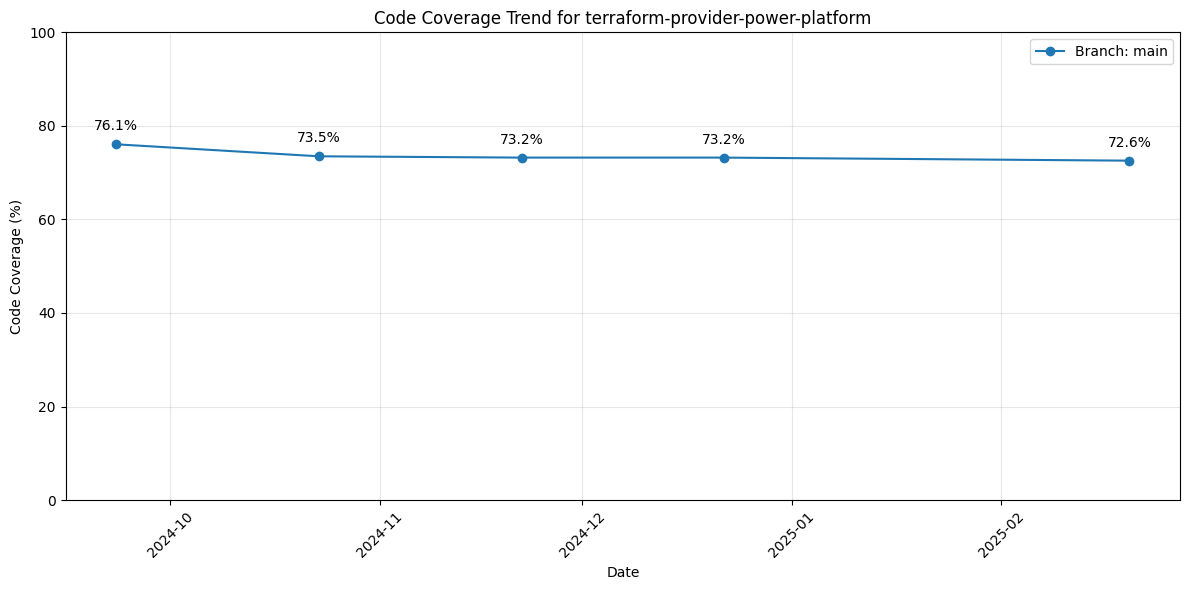

Latest coverage (2025-02-20): 72.56%


In [11]:
# Plot coverage trends
plt.figure(figsize=(12, 6))

# Group by branch and plot each as a separate line
for branch, data in df_coverage.groupby('branch'):
    line = plt.plot(data['timestamp'], data['coverage'], marker='o', label=f"Branch: {branch}")
    # Add data labels to each point
    for i, txt in enumerate(data['coverage']):
        plt.annotate(f"{txt:.1f}%", 
                    (data['timestamp'].iloc[i], data['coverage'].iloc[i]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

plt.xlabel('Date')
plt.ylabel('Code Coverage (%)')
plt.title('Code Coverage Trend for terraform-provider-power-platform')
plt.ylim(0, 100)  # Set y-axis to show full percentage range (0-100%)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print latest coverage
latest = df_coverage.loc[df_coverage['timestamp'].idxmax()]
print(f"Latest coverage ({latest['timestamp'].strftime('%Y-%m-%d')}): {latest['coverage']:.2f}%")


In [2]:
from github import Github
import pandas as pd
from datetime import datetime
import pandas as pd
import os

import matplotlib.pyplot as plt

token = os.getenv("GITHUB_TOKEN")
# Authenticate with GitHub
g = Github(token)

# Get the repository
repo = g.get_repo("microsoft/terraform-provider-power-platform")

# Fetch all issues (both open and closed), excluding PRs
issues = []
all_issues = repo.get_issues(state='all')
for issue in all_issues:
    # In GitHub's API, PRs are a type of issue with a pull_request property
    if not hasattr(issue, 'pull_request') or issue.pull_request is None:
        issues.append({
            'number': issue.number,
            'state': issue.state,
            'created_at': issue.created_at,
            'closed_at': issue.closed_at,
            'state_reason': issue.state_reason,
            'blocked': any(label.name.lower() == 'blocked' for label in issue.labels)
        })
        
# Print number of issues found for debugging
print(f"Found {len(issues)} issues (excluding PRs)")

# Convert to DataFrame
df_issues = pd.DataFrame(issues)

# Check if the DataFrame is empty before proceeding
if df_issues.empty:
    print("No issues found. Please check your GitHub repository access.")

    # Extract month-year for creation and closure dates
df_issues['created_month'] = pd.to_datetime(df_issues['created_at']).dt.strftime('%Y-%m')
df_issues['closed_month'] = pd.to_datetime(df_issues['closed_at']).dt.strftime('%Y-%m')

Found 217 issues (excluding PRs)


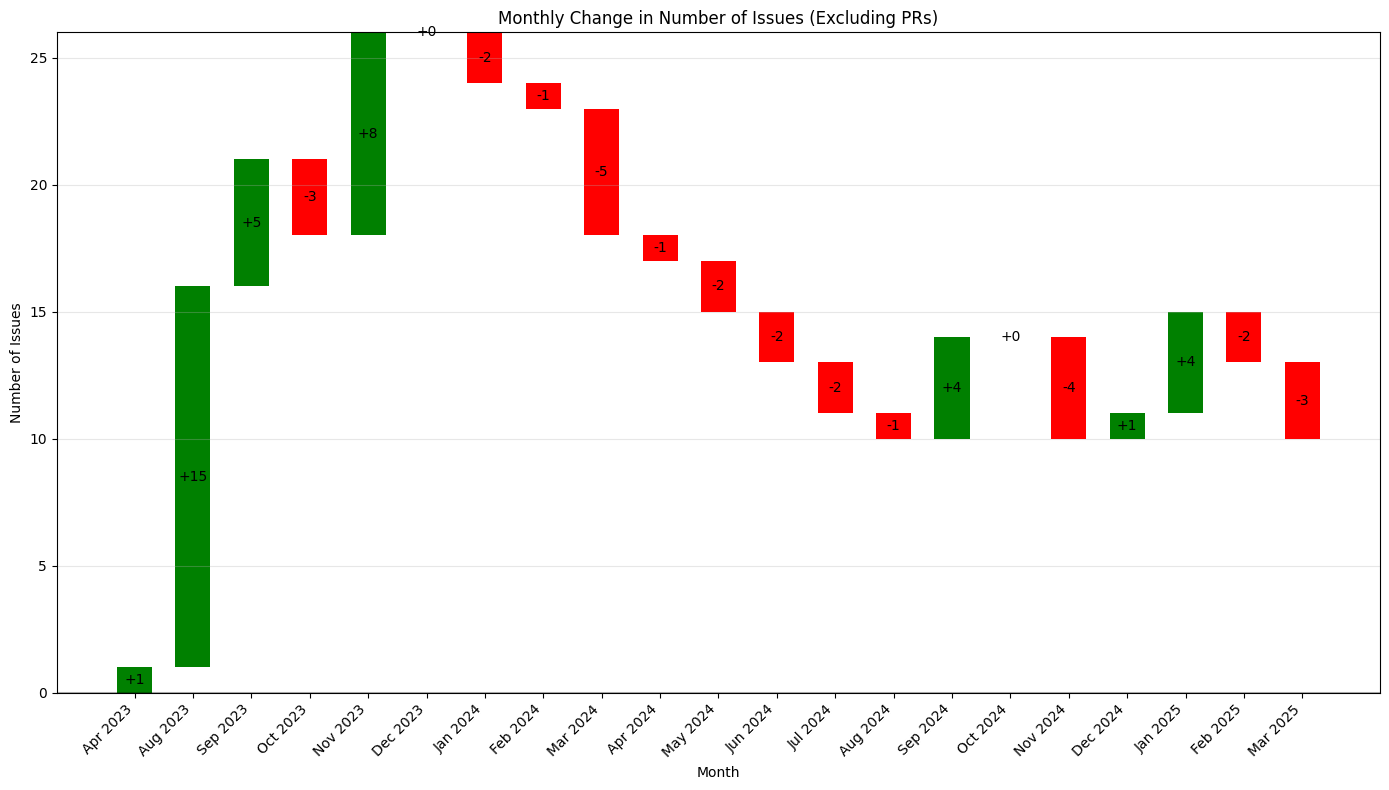

In [19]:

# Count opened issues by month
opened_by_month = df_issues.groupby('created_month').size().reset_index(name='opened')
opened_by_month['month'] = pd.to_datetime(opened_by_month['created_month'] + '-01')

# Count closed issues by month (excluding NaN values from still-open issues)
closed_by_month = df_issues.dropna(subset=['closed_month']).groupby('closed_month').size().reset_index(name='closed')
closed_by_month['month'] = pd.to_datetime(closed_by_month['closed_month'] + '-01')

# Merge the opened and closed data
monthly_changes = pd.merge(opened_by_month[['month', 'opened']], 
                          closed_by_month[['month', 'closed']], 
                          on='month', how='outer').fillna(0).sort_values('month')

# Calculate net change for each month
monthly_changes['net_change'] = monthly_changes['opened'] - monthly_changes['closed']

# Create the waterfall chart
plt.figure(figsize=(14, 8))

# Calculate the cumulative sum for the waterfall
monthly_changes['cumulative'] = monthly_changes['net_change'].cumsum()

# Create bars for each month
months = [date.strftime('%b %Y') for date in monthly_changes['month']]
colors = ['green' if x >= 0 else 'red' for x in monthly_changes['net_change']]

plt.bar(range(len(months)), monthly_changes['net_change'], 
        bottom=monthly_changes['cumulative'] - monthly_changes['net_change'], 
        color=colors, width=0.6)

# Format the plot
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(len(months)), months, rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Number of Issues')
plt.title('Monthly Change in Number of Issues (Excluding PRs)')

# Add annotations
for i, (change, cumulative) in enumerate(zip(monthly_changes['net_change'], monthly_changes['cumulative'])):
    if change >= 0:
        plt.text(i, cumulative - change/2, f"+{int(change)}", ha='center', va='center')
    else:
        plt.text(i, cumulative - change/2, f"{int(change)}", ha='center', va='center')

plt.tight_layout()
plt.show()


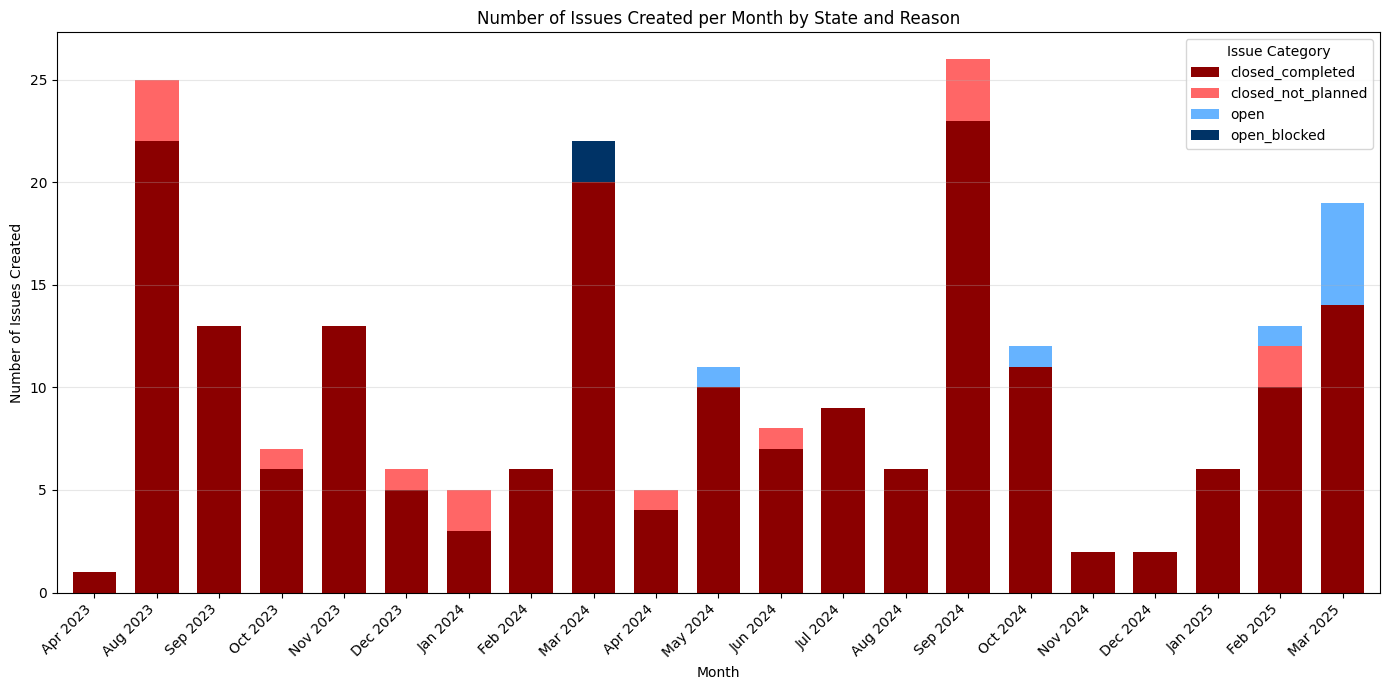

In [20]:
# Create a new column that combines state and state_reason for closed issues
df_issues['category'] = df_issues['state']
df_issues.loc[df_issues['state'] == 'closed', 'category'] = df_issues['state'] + '_' + df_issues['state_reason'].fillna('unknown')

# Group by created_month and category to get the count of issues
issues_by_month_category = df_issues.groupby(['created_month', 'category']).size().unstack(fill_value=0)

# Convert the index to datetime for proper sorting
issues_by_month_category.index = pd.to_datetime(issues_by_month_category.index + '-01')
issues_by_month_category = issues_by_month_category.sort_index()

# Create the stacked bar chart
plt.figure(figsize=(14, 7))

# First let's subcategorize open issues based on the 'blocked' field
# Create a temporary copy of the original dataframe
df_issues_temp = df_issues.copy()

# Update the category for blocked open issues
df_issues_temp.loc[(df_issues['state'] == 'open') & (df_issues['blocked'] == True), 'category'] = 'open_blocked'

# Group by created_month and category to get the count of issues with the new categories
issues_by_month_category = df_issues_temp.groupby(['created_month', 'category']).size().unstack(fill_value=0)

# Convert the index to datetime for proper sorting
issues_by_month_category.index = pd.to_datetime(issues_by_month_category.index + '-01')
issues_by_month_category = issues_by_month_category.sort_index()

# Define color scheme with different shades of red for closed categories
colors = {
    'open': '#66b3ff',            # Blue for open issues
    'open_blocked': '#003366',    # Dark blue for blocked open issues
    'closed_completed': '#8B0000', # Dark red for completed issues
    'closed_not_planned': '#FF6666', # Light red for not planned issues
    'closed_unknown': '#CD5C5C'   # Indian red for unknown reason
}

# Get the columns in the DataFrame and map to the colors dictionary
plot_colors = [colors.get(col, '#DC143C') for col in issues_by_month_category.columns]

# Create the stacked bar chart
issues_by_month_category.plot(kind='bar', stacked=True, ax=plt.gca(), 
                              color=plot_colors, width=0.7)

# Format x-axis labels to Month Year format
plt.gca().set_xticklabels([date.strftime('%b %Y') for date in issues_by_month_category.index])

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Number of Issues Created')
plt.title('Number of Issues Created per Month by State and Reason')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Issue Category')
plt.tight_layout()
plt.show()

Found data for 7 branches
Average branch lifetime: 0.89 days
Median branch lifetime: 0.38 days
Minimum branch lifetime: 0.01 days
Maximum branch lifetime: 2.50 days


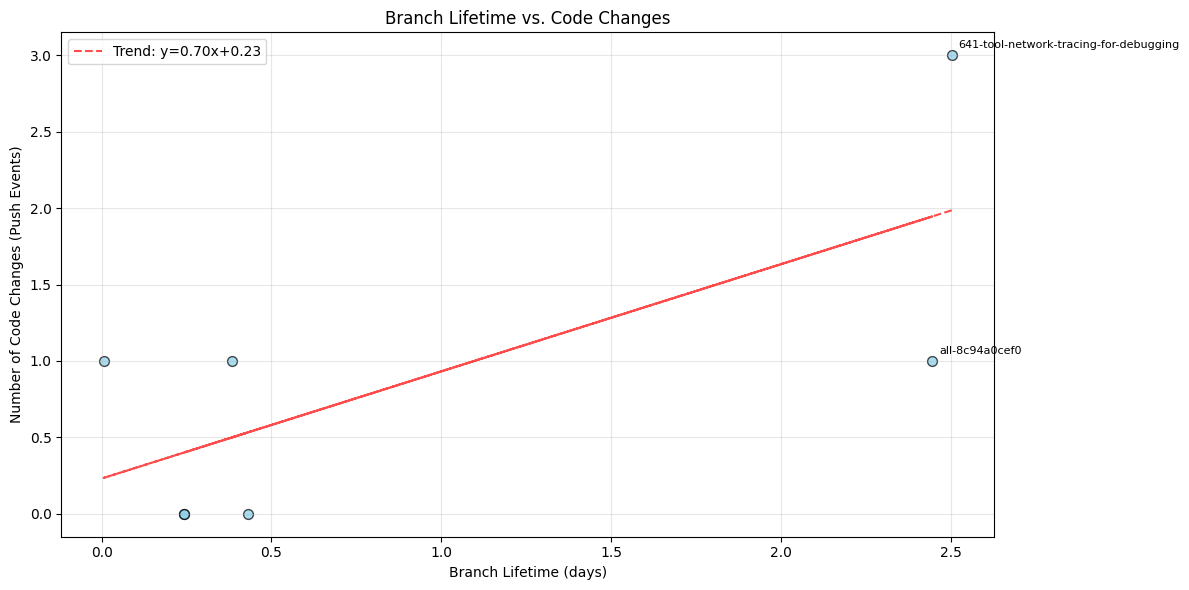


Top 10 branches by code changes:


,branch_name,creator,code_changes,lifetime_days
0,641-tool-network-tracing-for-debugging,mattdot,3,2.501701
1,mawasile/639-remove-testaccenvironmentsresourc...,mawasile,1,0.384086
4,mawasile613-all-possible-resources-attributes-...,mawasile,1,0.006134
5,dependabot/terraform/examples/resources/powerp...,dependabot[bot],1,2.444421
2,dependabot/terraform/examples/resources/powerp...,dependabot[bot],0,0.430810
3,dependabot/go_modules/golang.org/x/net-0.36.0,dependabot[bot],0,0.241447
6,dependabot/github_actions/dot-github/workflows...,dependabot[bot],0,0.243275


In [ ]:
import numpy as np

# Filter for branch creation events
branch_creations = df_events[(df_events['type'] == 'CreateEvent') & (df_events['ref_type'] == 'branch')]

# Create a dataframe to store branch lifecycle information
branch_lifecycle = []

# For each branch creation, find its deletion event and code changes
for _, creation_event in branch_creations.iterrows():
    branch_name = creation_event['ref']
    creation_time = creation_event['created_at']
    creator = creation_event['actor']
    
    # Look for DeleteEvent for this branch
    deletion_events = df_events[(df_events['type'] == 'DeleteEvent') & 
                               (df_events['ref'] == branch_name) & 
                               (df_events['created_at'] > creation_time)]
    
    # Track code changes by looking for PushEvents on this branch
    push_events = df_events[(df_events['type'] == 'PushEvent') & 
                           (df_events['ref'] == f'refs/heads/{branch_name}') &
                           (df_events['created_at'] > creation_time)]
    
    # Count the number of commits (proxy for code changes)
    code_changes = len(push_events)
    
    if not deletion_events.empty:
        # Take the earliest deletion event after creation
        deletion_event = deletion_events.iloc[0]
        deletion_time = deletion_event['created_at']
        deleter = deletion_event['actor']
        
        # Calculate time difference in days
        time_to_delete = (deletion_time - creation_time).total_seconds() / (60 * 60 * 24)  # convert to days
        
        branch_lifecycle.append({
            'branch_name': branch_name,
            'creation_time': creation_time,
            'creator': creator,
            'deletion_time': deletion_time,
            'deleter': deleter,
            'lifetime_days': time_to_delete,
            'code_changes': code_changes
        })

# Create DataFrame from branch lifecycle data
df_branch_lifecycle = pd.DataFrame(branch_lifecycle)

# Display statistics and visualizations if we have data
if not df_branch_lifecycle.empty:
    # Show basic statistics
    print(f"Found data for {len(df_branch_lifecycle)} branches")
    print(f"Average branch lifetime: {df_branch_lifecycle['lifetime_days'].mean():.2f} days")
    print(f"Median branch lifetime: {df_branch_lifecycle['lifetime_days'].median():.2f} days")
    print(f"Minimum branch lifetime: {df_branch_lifecycle['lifetime_days'].min():.2f} days")
    print(f"Maximum branch lifetime: {df_branch_lifecycle['lifetime_days'].max():.2f} days")
    
    # Create a scatter plot of branch lifetimes vs code changes
    plt.figure(figsize=(12, 6))
    plt.scatter(df_branch_lifecycle['lifetime_days'], df_branch_lifecycle['code_changes'], 
                alpha=0.7, s=50, c='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Branch Lifetime (days)')
    plt.ylabel('Number of Code Changes (Push Events)')
    plt.title('Branch Lifetime vs. Code Changes')
    
    # Add trend line
    z = np.polyfit(df_branch_lifecycle['lifetime_days'], df_branch_lifecycle['code_changes'], 1)
    p = np.poly1d(z)
    plt.plot(df_branch_lifecycle['lifetime_days'], p(df_branch_lifecycle['lifetime_days']), 
             "r--", alpha=0.7, label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}")
    
    # Add branch names as tooltips for interesting data points
    for i, row in df_branch_lifecycle.iterrows():
        if row['code_changes'] > 2 or row['lifetime_days'] > 1.5:  # Highlight important branches
            plt.annotate(row['branch_name'].split('/')[-1], 
                         (row['lifetime_days'], row['code_changes']),
                         textcoords="offset points",
                         xytext=(5, 5),
                         fontsize=8)
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Top 10 branches by code changes
    print("\nTop 10 branches by code changes:")
    display(df_branch_lifecycle.sort_values('code_changes', ascending=False).head(10)[
        ['branch_name', 'creator', 'code_changes', 'lifetime_days']])
else:
    print("No branch lifecycle data could be calculated.")

Retrieved 100 PRs. Total so far: 100. Has next page: True
Retrieved 100 PRs. Total so far: 200. Has next page: True
Retrieved 100 PRs. Total so far: 300. Has next page: True
Retrieved 100 PRs. Total so far: 400. Has next page: True
Retrieved 10 PRs. Total so far: 410. Has next page: False
Retrieved a total of 410 PRs


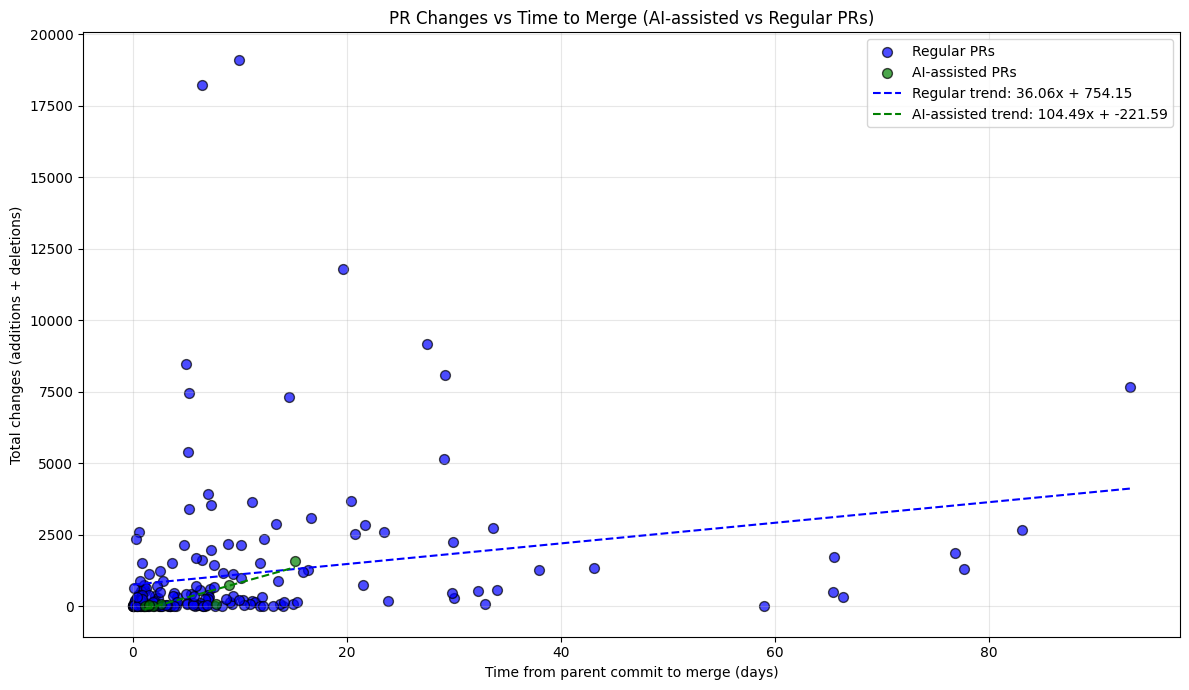


Statistics:
Average changes in regular PRs: 1110.4226804123712
Average changes in AI-assisted PRs: 360.85714285714283
Average time to merge for regular PRs: 9.881136407025583 days
Average time to merge for AI-assisted PRs: 5.574332010582011 days


In [1]:
import requests
import json
from datetime import datetime
from github import Github
import pandas as pd
from datetime import datetime
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

token = os.getenv("GITHUB_TOKEN")
# Authenticate with GitHub
g = Github(token)

# Get the repository
repo = g.get_repo("microsoft/terraform-provider-power-platform")

# Setup for GitHub GraphQL API
url = "https://api.github.com/graphql"
headers = {
  "Authorization": f"Bearer {token}",
  "Content-Type": "application/json"
}

# Initialize an empty list to store all PR data
all_prs = []

# Initialize pagination variables
has_next_page = True
end_cursor = None

# Start paginating through results
while has_next_page:
  # The GraphQL query with pagination support
  query = """
  query($cursor: String) {
    repository(owner: "microsoft", name: "terraform-provider-power-platform") {
    pullRequests(first: 100, after: $cursor, orderBy: { field: CREATED_AT, direction: DESC }) {
      nodes {
      title
      number
      state
      merged
      mergedAt
      createdAt
      additions
      deletions
      changedFiles
      closingIssuesReferences(first: 20) {
        nodes {
        id
        labels(first:20) { 
          nodes {
          name
          }
        }
        issueType {
          name
        }
        }
      }
      author {
        login
      }
      headRefName
      baseRefName
      firstCommit: commits(first: 1) {
        nodes {
        commit {
          parents(first: 1) {
          nodes {
            committedDate
          }
          }
          committedDate
        }
        }
      }
      lastCommit: commits(last: 1) {
        nodes {
        commit {
          committedDate
        }
        }
      }
      labels(first:20) {
        nodes {
        name
        }
      }
      }
      pageInfo {
      endCursor
      hasNextPage
      }
    }
    }
  }
  """
  
  # Define variables for the query
  variables = {"cursor": end_cursor}
  
  # Make the request to GitHub GraphQL API
  response = requests.post(url, headers=headers, json={"query": query, "variables": variables})
  result = response.json()
  
  # Check if the request was successful
  if "errors" in result:
    print("Error in GraphQL query:")
    for error in result["errors"]:
      print(f"- {error['message']}")
    break
  else:
    # Extract the pull requests and page info
    prs = result["data"]["repository"]["pullRequests"]["nodes"]
    page_info = result["data"]["repository"]["pullRequests"]["pageInfo"]
    
    # Add the PRs to our collection
    all_prs.extend(prs)
    
    # Update pagination info
    has_next_page = page_info["hasNextPage"]
    end_cursor = page_info["endCursor"]
    
    print(f"Retrieved {len(prs)} PRs. Total so far: {len(all_prs)}. Has next page: {has_next_page}")

# Process all the retrieved PRs
print(f"Retrieved a total of {len(all_prs)} PRs")

# Convert to DataFrame for easier analysis
pr_data = []
for pr in all_prs:
  # Extract label names
  labels = [label["name"] for label in pr["labels"]["nodes"]]
  is_ai_assisted = any("ai assisted" in label.lower() for label in labels)
  
  # Extract dates
  created_at = datetime.fromisoformat(pr["createdAt"].replace("Z", "+00:00"))
  merged_at = None
  if pr["mergedAt"]:
    merged_at = datetime.fromisoformat(pr["mergedAt"].replace("Z", "+00:00"))
    
  # Get first and last commit dates if available
  first_commit_date = None
  parent_commit_date = None
  last_commit_date = None
  
  if pr["firstCommit"]["nodes"]:
    first_commit = pr["firstCommit"]["nodes"][0]["commit"]
    first_commit_date = datetime.fromisoformat(first_commit["committedDate"].replace("Z", "+00:00"))
    if first_commit["parents"]["nodes"]:
      parent_commit_date = datetime.fromisoformat(
        first_commit["parents"]["nodes"][0]["committedDate"].replace("Z", "+00:00")
      )
  
  if pr["lastCommit"]["nodes"]:
    last_commit_date = datetime.fromisoformat(
      pr["lastCommit"]["nodes"][0]["commit"]["committedDate"].replace("Z", "+00:00")
    )
  
  pr_data.append({
    "number": pr["number"],
    "title": pr["title"],
    "author": pr["author"]["login"] if pr["author"] else "Unknown",
    "state": pr["state"],
    "merged": pr["merged"],
    "created_at": created_at,
    "merged_at": merged_at,
    "head_branch": pr["headRefName"],
    "base_branch": pr["baseRefName"],
    "first_commit_date": first_commit_date,
    "parent_commit_date": parent_commit_date,
    "last_commit_date": last_commit_date,
    "additions": pr["additions"],
    "deletions": pr["deletions"],
    "changes": pr["additions"] + pr["deletions"],
    "changed_files": pr["changedFiles"],
    "labels": labels,
    "is_ai_assisted": is_ai_assisted,
    "parent_to_merged_days": (merged_at - parent_commit_date).total_seconds() / (60 * 60 * 24) if merged_at and parent_commit_date else None,
    "parent_to_created_days": (created_at - parent_commit_date).total_seconds() / (60 * 60 * 24) if created_at and parent_commit_date else None,
    "time_to_merge_days": (merged_at - created_at).total_seconds() / (60 * 60 * 24) if merged_at and created_at else None
  })
  
df_graphql_prs = pd.DataFrame(pr_data)
# Filter out PRs from dependabot and unmerged PRs
filtered_df = df_graphql_prs[
  (~df_graphql_prs['author'].apply(lambda x: x is not None and 'dependabot' in str(x).lower())) & 
  (df_graphql_prs['merged'] == True)
]

# display(filtered_df)
# Create a scatter plot of PR changes vs time from parent commit to merge
plt.figure(figsize=(12, 7))

# Plot non-AI-assisted PRs
non_ai = filtered_df[filtered_df['is_ai_assisted'] == False]
plt.scatter(non_ai['parent_to_merged_days'], non_ai['changes'], 
  alpha=0.7, s=50, color='blue', label='Regular PRs', edgecolor='black')

# Plot AI-assisted PRs
ai = filtered_df[filtered_df['is_ai_assisted'] == True]
plt.scatter(ai['parent_to_merged_days'], ai['changes'], 
  alpha=0.7, s=50, color='green', label='AI-assisted PRs', edgecolor='black')

# Add trend lines

# Add trend line for non-AI-assisted PRs if there are enough data points
if len(non_ai) > 1:
  z = np.polyfit(non_ai['parent_to_merged_days'], non_ai['changes'], 1)
  p = np.poly1d(z)
  plt.plot(sorted(non_ai['parent_to_merged_days']), p(sorted(non_ai['parent_to_merged_days'])), 
    color='blue', linestyle='--', 
    label=f'Regular trend: {z[0]:.2f}x + {z[1]:.2f}')

# Add trend line for AI-assisted PRs if there are enough data points
if len(ai) > 1:
  z_ai = np.polyfit(ai['parent_to_merged_days'], ai['changes'], 1)
  p_ai = np.poly1d(z_ai)
  plt.plot(sorted(ai['parent_to_merged_days']), p_ai(sorted(ai['parent_to_merged_days'])), 
    color='green', linestyle='--', 
    label=f'AI-assisted trend: {z_ai[0]:.2f}x + {z_ai[1]:.2f}')

# Add labels and title
plt.xlabel('Time from parent commit to merge (days)')
plt.ylabel('Total changes (additions + deletions)')
plt.title('PR Changes vs Time to Merge (AI-assisted vs Regular PRs)')

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Display some statistics
print("\nStatistics:")
print("Average changes in regular PRs:", non_ai['changes'].mean())
print("Average changes in AI-assisted PRs:", ai['changes'].mean())
print("Average time to merge for regular PRs:", non_ai['parent_to_merged_days'].mean(), "days")
print("Average time to merge for AI-assisted PRs:", ai['parent_to_merged_days'].mean(), "days")


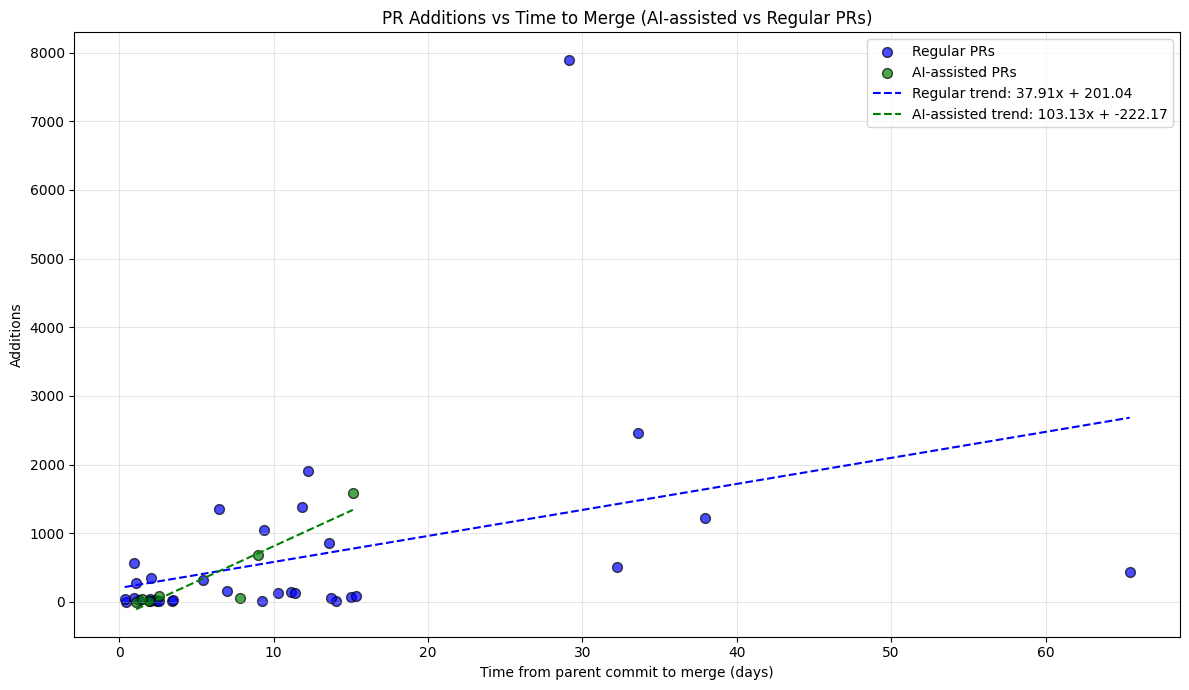


Statistics:
Average additions in regular PRs: 635.7647058823529
Average additions in AI-assisted PRs: 352.7142857142857
Average time to merge for regular PRs: 11.467882625272331 days
Average time to merge for AI-assisted PRs: 5.574332010582011 days


In [3]:
# Create a scatter plot of PR additions vs time from parent commit to merge
plt.figure(figsize=(12, 7))

# Plot non-AI-assisted PRs
non_ai = filtered_df[filtered_df['is_ai_assisted'] == False]
plt.scatter(non_ai['parent_to_merged_days'], non_ai['additions'], 
    alpha=0.7, s=50, color='blue', label='Regular PRs', edgecolor='black')

# Plot AI-assisted PRs
ai = filtered_df[filtered_df['is_ai_assisted'] == True]
plt.scatter(ai['parent_to_merged_days'], ai['additions'], 
    alpha=0.7, s=50, color='green', label='AI-assisted PRs', edgecolor='black')

# Add trend lines
# Add trend line for non-AI-assisted PRs if there are enough data points
if len(non_ai) > 1:
    z = np.polyfit(non_ai['parent_to_merged_days'], non_ai['additions'], 1)
    p = np.poly1d(z)
    plt.plot(sorted(non_ai['parent_to_merged_days']), p(sorted(non_ai['parent_to_merged_days'])), 
        color='blue', linestyle='--', 
        label=f'Regular trend: {z[0]:.2f}x + {z[1]:.2f}')

# Add trend line for AI-assisted PRs if there are enough data points
if len(ai) > 1:
    z_ai = np.polyfit(ai['parent_to_merged_days'], ai['additions'], 1)
    p_ai = np.poly1d(z_ai)
    plt.plot(sorted(ai['parent_to_merged_days']), p_ai(sorted(ai['parent_to_merged_days'])), 
        color='green', linestyle='--', 
        label=f'AI-assisted trend: {z_ai[0]:.2f}x + {z_ai[1]:.2f}')

# Add labels and title
plt.xlabel('Time from parent commit to merge (days)')
plt.ylabel('Additions')
plt.title('PR Additions vs Time to Merge (AI-assisted vs Regular PRs)')

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Display some statistics
print("\nStatistics:")
print("Average additions in regular PRs:", non_ai['additions'].mean())
print("Average additions in AI-assisted PRs:", ai['additions'].mean())
print("Average time to merge for regular PRs:", non_ai['parent_to_merged_days'].mean(), "days")
print("Average time to merge for AI-assisted PRs:", ai['parent_to_merged_days'].mean(), "days")